<a href="https://colab.research.google.com/github/tharinda3518/colab_developments/blob/main/PBE_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required for First Time. Installation of pyspark, setting up Java and building Session. NOT NEEDED NOW

In [4]:

# Apache Spark uses Java, so first we must install that
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

from google.colab import drive
drive.mount('/content/drive')
!tar xzf /content/drive/MyDrive/spark-3.3.0-bin-hadoop3.tgz

# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

# Install findspark, which helps python locate the psyspark module files
!pip install -q findspark
import findspark
findspark.init()

# Import Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd
import warnings
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandas import read_csv
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, BooleanType, StringType
warnings.filterwarnings("ignore")

# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("PBE_structured_FNL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

^C
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### Install Pyspark and set Java_Home first time

In [5]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
# Import excel write module
!pip install xlsxwriter

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=1d6a174845bebe68c1f01c6e0fe208d45029ba53b46259a2d65e6210930e7267
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


openjdk-8-jdk-headless is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


### Importing Required Libraries and building Spark session

In [ ]:
'''
# Import Libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql import Window
import pandas as pd
import warnings
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from pandas import read_csv
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, BooleanType, StringType
warnings.filterwarnings("ignore")

# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("PBE_structured_FNL")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
'''

### Add py Files to sparkcontext path for distributed processing of Spark workers

In [6]:
sc = spark.sparkContext
sc.addPyFile('/content/drive/MyDrive/PBE_Code/PBE_Validations.py')
sc.addPyFile('/content/drive/MyDrive/PBE_Code/PBE_Transformation.py')

### Load supporting Notebooks

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
cd /content/drive/MyDrive/PBE_Code

/content/drive/MyDrive/PBE_Code


In [10]:
!pip install import_ipynb
import import_ipynb
from PBE_Transformation import DataProcessor
from PBE_Validations import DataValidationHandler
from Ingest_Write import SQLServerDataHandler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.7 MB/s eta 0:00:00


### **Main Method**

In [32]:
def main (write_mode='N'):
    file_path = "/content/drive/MyDrive/MUG/FileWith5Inverters - SET II.csv"


    # Create an instance of the SQLServerDataHandler class
    # Used for data Load and Write
    data_handler = SQLServerDataHandler(spark)
    result_df=data_handler.load_inverter_data(file_path) # Loading data from csv file. This will change to load data directly from DB table.

    missing_threshold=2880

    # Create an instance of the DataValidationHandler class
    # performing 1st Level Generic Validations here
    validation_handler= DataValidationHandler(spark,missing_threshold)
    df_gen_val_succeded, df_gen_val_failed = validation_handler.perform_generic_validations(result_df)

    # Create an instance of the  DataProcessor(Data Transformation) class
    # Making full data 365 along with creating dervied and inst columns
    data_transformation_handler=DataProcessor(spark)
    df_merge_ready_py=data_transformation_handler.make_full_data(df_gen_val_succeded)
    df_validate_ready=data_transformation_handler.generate_derived_inst_col(df_merge_ready_py)

    # Performing Level 2 Data validations here
    df_validated=validation_handler.validate_data_udf(df_validate_ready)
    print('Checkpoint 4')

    # Cleaning validated data here
    df_tot_cleansed=data_transformation_handler.cleaning_validated_data(df_validated)

    print('Checkpoint 5')
    # Re-execute validation to re validate records after cleansing
    df_tot_cleansed_n_validated=validation_handler.validate_data_udf(df_tot_cleansed)
    print('Checkpoint 6')

    ''' Replcing any left over record with NaN value with bfill'''
    # Convert PySpark DataFrame to Pandas DataFrame
    df_tot_cleansed_n_validated_pd = df_tot_cleansed_n_validated.toPandas()   # This should be converted to Pyspark
    print('Checkpoint 6.1')
    df_processed = data_transformation_handler.process_fillna(df_tot_cleansed_n_validated_pd)  # This should be converted to Pyspark
    print('Checkpoint 7')

    # Writing data in excel below. This will be changed to store data directly to DB tables.
    if (write_mode == 'Y'):
      path = '/content/drive/MyDrive/MUG/'
      df_gen_val_failed_pd = df_gen_val_failed.toPandas()
      df_validated_pd = df_validated.toPandas()
      export_records_to_excel(df_processed, 'S', path)
      export_records_to_excel(df_gen_val_failed_pd, 'F', path)
      export_records_to_excel(df_validated_pd, 'V', path)

    return df_tot_cleansed_n_validated, df_gen_val_failed, df_validated

### **Invoke Main Function**

In [34]:
if __name__ == "__main__":
    df_tot_cleansed_n_validated, df_gen_val_failed, df_validated = main('Y')

H1E502F6135060
H1E502F6135061
H1E502F6135062
Checkpoint 1
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 4.1
Checkpoint 4.2
Checkpoint 4.3
Checkpoint 4.4
Checkpoint 5
Checkpoint 5
Checkpoint 6
Checkpoint 6.1
Checkpoint 7


### **Output**

In [33]:
def export_records_to_excel(df_failed, is_succ_failed, location):
    """
    Export failed PySpark DataFrame records to an Excel file, creating separate sheets for each unique serial number.

    Parameters:
    - df_failed (pandas.DataFrame): Pandas DataFrame containing failed records.
    - is_succ_failed (str): Indicator ('S' for success, 'F' for failure) to determine the file name.

    Returns:
    - None
    """

    # Get the current datetime and format it
    current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

    # Define the file_path_with_datetime based on success or failure
    if is_succ_failed == 'S':
        file_path_with_datetime = f'Success_{current_datetime}.xlsx'
    elif is_succ_failed == 'F':
        file_path_with_datetime = f'Failed_{current_datetime}.xlsx'
    elif is_succ_failed == 'V':
        file_path_with_datetime = f'Flagged_{current_datetime}.xlsx'
    else:
        raise ValueError("is_succ_failed should be 'S' for success or 'F' for failure.")

    # Append location to the file path
    file_path_with_datetime = location + file_path_with_datetime

    # Get unique serial numbers
    unique_serial_numbers = df_failed['inverter_serial_no'].unique()

    # Create an Excel writer object
    excel_writer = pd.ExcelWriter(file_path_with_datetime, engine='xlsxwriter')

    # Loop through each unique serial number
    for serial_number in unique_serial_numbers:
        # Filter the DataFrame for the current serial number
        processed_df_pd_failed_tmp = df_failed[df_failed['inverter_serial_no'] == serial_number]

        # Write the filtered DataFrame to a new sheet
        sheet_name = f'inv_{serial_number}'
        processed_df_pd_failed_tmp.to_excel(excel_writer, sheet_name=sheet_name, index=False)

    # Save the Excel file
    excel_writer.save()

# EDA

In [35]:
# Import libariries needed for EDA
import seaborn as sns
import matplotlib.pyplot as plt


In [36]:
# Convert PySpark DataFrame to Pandas DataFrame
eda_df_pd = df_tot_cleansed_n_validated.toPandas()

## Identification of Data Outliers

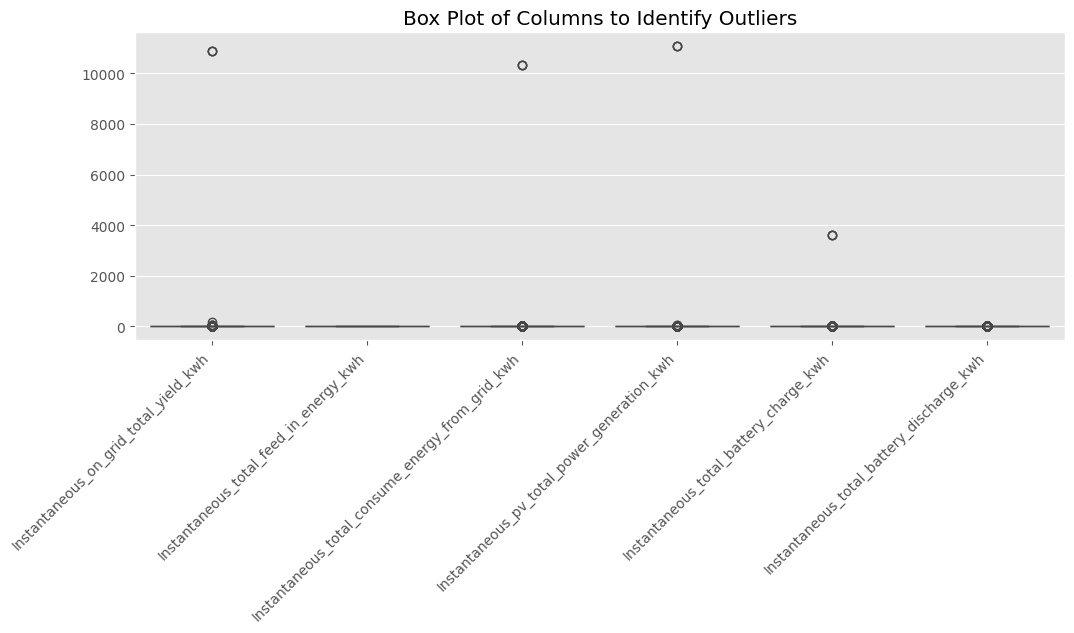

In [38]:
# Select the relevant columns
selected_columns = ['Instantaneous_on_grid_total_yield_kwh',
                    'Instantaneous_total_feed_in_energy_kwh',
                    'Instantaneous_total_consume_energy_from_grid_kwh',
                    'Instantaneous_pv_total_power_generation_kwh',
                    'Instantaneous_total_battery_charge_kwh',
                    'Instantaneous_total_battery_discharge_kwh']

# Create box plots for each column
plt.figure(figsize=(12, 4))
sns.boxplot(data=eda_df_pd[selected_columns])
plt.title('Box Plot of Columns to Identify Outliers')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.style.use('ggplot')
plt.show()

## Identification of trends and patters

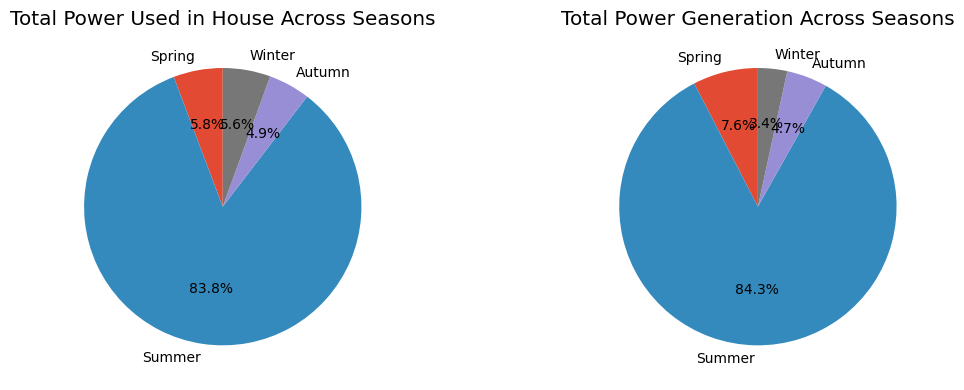

In [39]:
# Set the figure size
plt.figure(figsize=(12, 4))  # Adjust the values as needed

# Aggregating total power usage for each season
season_totals = df_tot_cleansed_n_validated.groupBy('Season').sum('Total_power_used_in_house').collect()

# Extracting data for the first pie chart
season_labels = [row['Season'] for row in season_totals]
power_values = [row['sum(Total_power_used_in_house)'] for row in season_totals]

# Plotting the first pie chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.pie(power_values, labels=season_labels, autopct='%1.1f%%', startangle=90)
plt.title('Total Power Used in House Across Seasons')

# Aggregating total power usage for each season
season_totals_for_feedIn = df_tot_cleansed_n_validated.groupBy('Season').sum('Instantaneous_pv_total_power_generation_kwh').collect()

# Extracting data for the second pie chart
season_labels_feedIn = [row['Season'] for row in season_totals_for_feedIn]
power_values_feedIn = [row['sum(Instantaneous_pv_total_power_generation_kwh)'] for row in season_totals_for_feedIn]

# Apply a style sheet
plt.style.use('ggplot')

# Plotting the second pie chart
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.pie(power_values_feedIn, labels=season_labels_feedIn, autopct='%1.1f%%', startangle=90)
plt.title('Total Power Generation Across Seasons')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

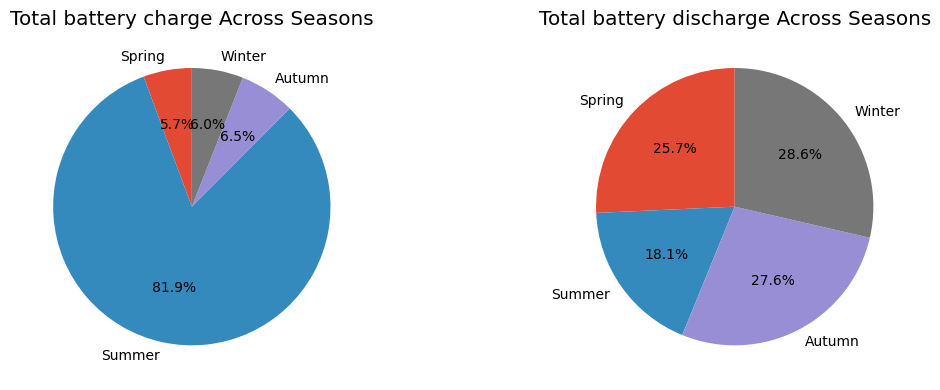

In [40]:
# Set the figure size
plt.figure(figsize=(12, 4))  # Adjust the values as needed

# Aggregating total battery usage for each season
season_totals_for_bc = df_tot_cleansed_n_validated.groupBy('Season').sum('Instantaneous_total_battery_charge_kwh').collect()

# Extracting data for the second pie chart
season_labels_bc = [row['Season'] for row in season_totals_for_bc]
power_values_bc = [row['sum(Instantaneous_total_battery_charge_kwh)'] for row in season_totals_for_bc]

# Apply a style sheet
plt.style.use('ggplot')

# Plotting the second pie chart
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 2
plt.pie(power_values_bc, labels=season_labels_bc, autopct='%1.1f%%', startangle=90)
plt.title('Total battery charge Across Seasons')


# Total battery discharge
season_totals_for_bdc = df_tot_cleansed_n_validated.groupBy('Season').sum('Instantaneous_total_battery_discharge_kwh').collect()

# Extracting data for the second pie chart
season_labels_bdc = [row['Season'] for row in season_totals_for_bc]
power_values_bdc = [row['sum(Instantaneous_total_battery_discharge_kwh)'] for row in season_totals_for_bdc]

# Plotting the second pie chart
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.pie(power_values_bdc, labels=season_labels_bdc, autopct='%1.1f%%', startangle=90)
plt.title('Total battery discharge Across Seasons')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

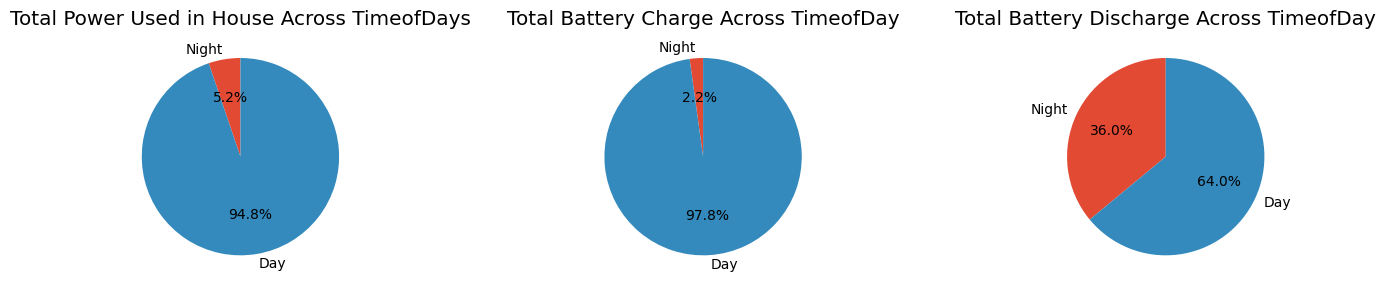

In [41]:

# Set the figure size
plt.figure(figsize=(15, 3))  # Adjust the values as needed

# Aggregating total power usage for each TimeofDay
TimeofDay_totals = df_tot_cleansed_n_validated.groupBy('TimeofDay').sum('Total_power_used_in_house').collect()

# Extracting data for the first pie chart
TimeofDay_labels = [row['TimeofDay'] for row in TimeofDay_totals]
power_values_TimeofDay = [row['sum(Total_power_used_in_house)'] for row in TimeofDay_totals]

# Plotting the first pie chart
plt.subplot(1, 3, 1)  # 1 row, 3 columns, position 1
plt.pie(power_values_TimeofDay, labels=TimeofDay_labels, autopct='%1.1f%%', startangle=90)
plt.title('Total Power Used in House Across TimeofDays')
plt.style.use('ggplot')

# Aggregating total battery usage for each TimeofDay
TimeofDay_totals_for_bc = df_tot_cleansed_n_validated.groupBy('TimeofDay').sum('Instantaneous_total_battery_charge_kwh').collect()

# Extracting data for the second pie chart
TimeofDay_labels_bc = [row['TimeofDay'] for row in TimeofDay_totals_for_bc]
power_values_bc_TimeofDay = [row['sum(Instantaneous_total_battery_charge_kwh)'] for row in TimeofDay_totals_for_bc]

# Plotting the second pie chart
plt.subplot(1, 3, 2)  # 1 row, 3 columns, position 2
plt.pie(power_values_bc_TimeofDay, labels=TimeofDay_labels_bc, autopct='%1.1f%%', startangle=90)
plt.title('Total Battery Charge Across TimeofDay')
plt.style.use('ggplot')

# Total battery discharge
TimeofDay_totals_for_bdc = df_tot_cleansed_n_validated.groupBy('TimeofDay').sum('Instantaneous_total_battery_discharge_kwh').collect()

# Extracting data for the third pie chart
TimeofDay_labels_bdc = [row['TimeofDay'] for row in TimeofDay_totals_for_bdc]
power_values_bdc_TimeofDay = [row['sum(Instantaneous_total_battery_discharge_kwh)'] for row in TimeofDay_totals_for_bdc]

# Plotting the third pie chart
plt.subplot(1, 3, 3)  # 1 row, 3 columns, position 3
plt.pie(power_values_bdc_TimeofDay, labels=TimeofDay_labels_bdc, autopct='%1.1f%%', startangle=90)
plt.title('Total Battery Discharge Across TimeofDay')
plt.style.use('ggplot')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

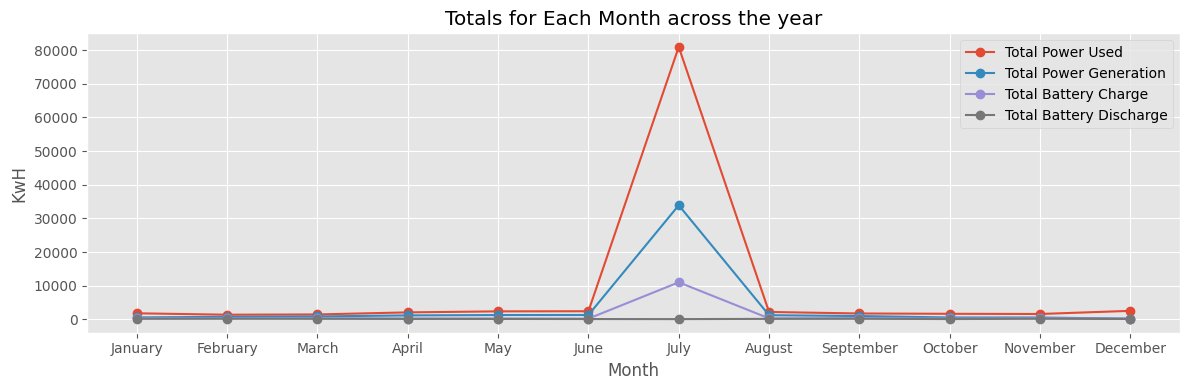

In [42]:
# Aggregating total power usage for each month
monthly_totals_power = eda_df_pd.groupby('month')['Total_power_used_in_house'].sum()

# Aggregating total power generation for each month
monthly_totals_pv_generation = eda_df_pd.groupby('month')['Instantaneous_pv_total_power_generation_kwh'].sum()

# Aggregating total battery charge for each month
monthly_totals_battery_charge = eda_df_pd.groupby('month')['Instantaneous_total_battery_charge_kwh'].sum()

# Aggregating total battery charge for each month
monthly_totals_battery_discharge = eda_df_pd.groupby('month')['Instantaneous_total_battery_discharge_kwh'].sum()

# Define month names
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting multiple line charts
plt.figure(figsize=(12, 4))

'''
# Line chart for Total Power Used in House
plt.subplot(2, 1, 1)
monthly_totals_power.plot(marker='o', linestyle='-', label='Total Power Used in House')
plt.title('Total Power Used in House for Each Month')
plt.xlabel('Month')
plt.ylabel('Total Power Used in House')
plt.xticks(monthly_totals_power.index, [month_names[month - 1] for month in monthly_totals_power.index])  # Adjust the indexing if needed
plt.legend()
plt.grid(True)
plt.style.use('ggplot')
'''

# Line chart for Total Power Generation and Total Battery Charge
#plt.subplot(2, 1, 2)
monthly_totals_power.plot(marker='o', linestyle='-', label='Total Power Used')
monthly_totals_pv_generation.plot(marker='o', linestyle='-', label='Total Power Generation')
monthly_totals_battery_charge.plot(marker='o', linestyle='-', label='Total Battery Charge')
monthly_totals_battery_discharge.plot(marker='o', linestyle='-', label='Total Battery Discharge')

plt.title('Totals for Each Month across the year')
plt.xlabel('Month')
plt.ylabel('KwH')
plt.xticks(monthly_totals_power.index, [month_names[month - 1] for month in monthly_totals_power.index])
plt.legend()
plt.grid(True)
plt.style.use('ggplot')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

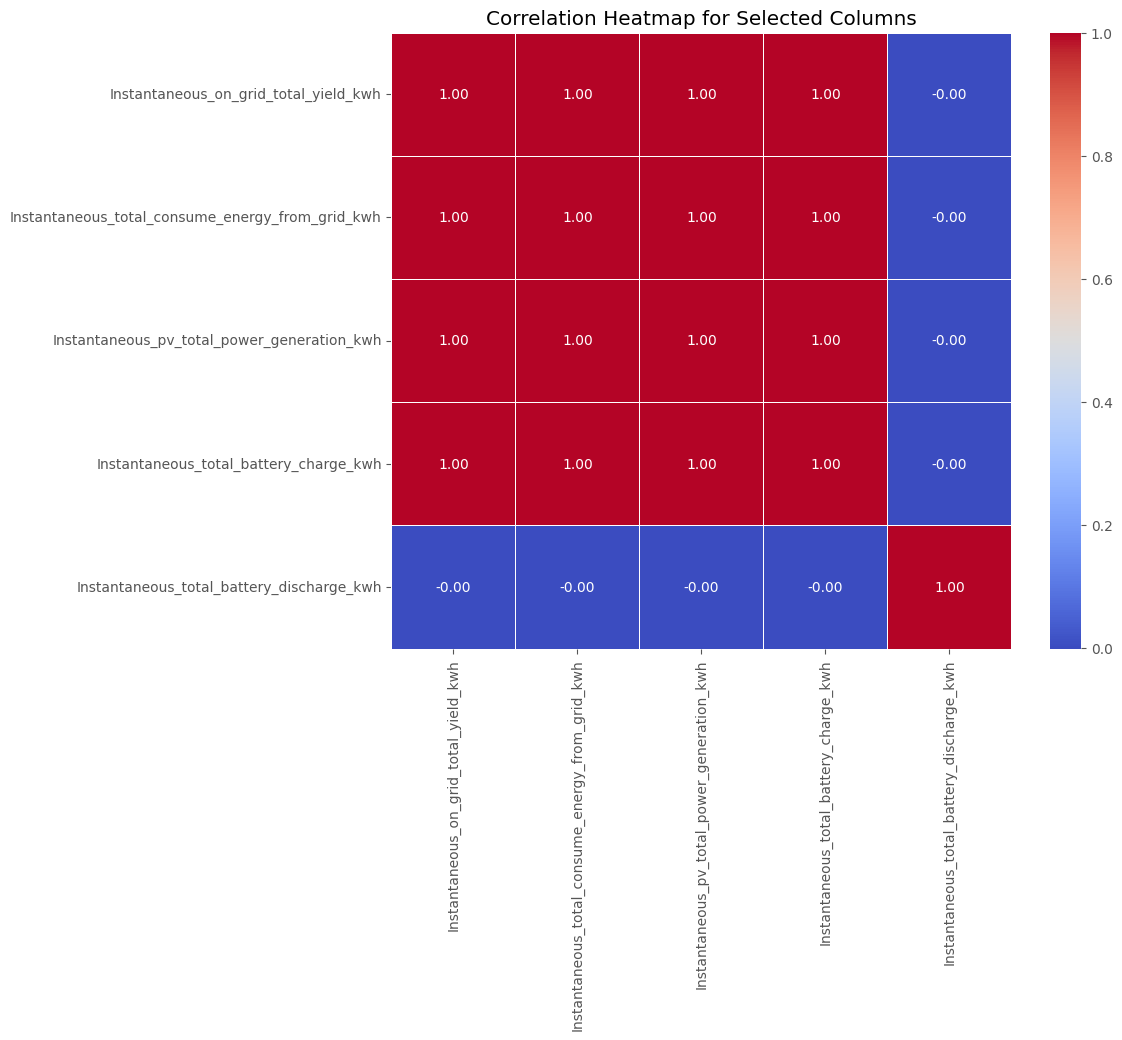

In [43]:
# Select the relevant columns
selected_columns = ['Instantaneous_on_grid_total_yield_kwh',
                  #  'Instantaneous_total_feed_in_energy_kwh', --Add later ??
                    'Instantaneous_total_consume_energy_from_grid_kwh',
                    'Instantaneous_pv_total_power_generation_kwh',
                    'Instantaneous_total_battery_charge_kwh',
                    'Instantaneous_total_battery_discharge_kwh']

# Create a correlation matrix
correlation_matrix = eda_df_pd[selected_columns].corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Selected Columns')
plt.show()